In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
#from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.initializers import RandomUniform
 
# define the standalone discriminator model
def define_discriminator(in_shape):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))   
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0004, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
# define the standalone generator model
def define_generator(latent_dim, output_shape):
    start_height = output_shape[0] // 8
    start_width = output_shape[1] // 8
    final_channels = output_shape[2]
    
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * start_width * start_height
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((start_height, start_width , 256)))
    # upsample to 2*start_width x 2*start_height
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 4*start_width x 4*start_height
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 8*start_width x 8*start_height
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # output layer
    model.add(Conv2D(final_channels, (3,3), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, loss='binary_crossentropy', optimizer=None):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    if not optimizer:
        optimizer = Adam(lr=0.0004, beta_1=0.5)
    model.compile(loss=loss, optimizer=optimizer)
    return model
 

In [15]:
import numpy as np
import os
from PIL import Image

# select real samples
def generate_real_samples(dataset, n_samples, multiplier=1.0):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = np.ones((n_samples, 1)) * multiplier
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, multiplier=1.0):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = np.ones((n_samples, 1)) * multiplier
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# train the generator and discriminator
def train(genenerator, discriminator, gan_model, dataset, latent_dim, output_path,
          real_samples_multiplier=1.0, fake_samples_multiplier=0.0, discriminator_batches=1,
          n_epochs=200, n_batch=128):
    batch_per_epoch = dataset.shape[0] // n_batch
    half_batch = n_batch // 2
    seed = generate_latent_points(latent_dim, 54)
    n_steps = batch_per_epoch * n_epochs
	
    history = {'discriminator_real_loss': [],
               'discriminator_fake_loss': [],
               'generator_loss': []}
    for step in range(n_steps):
        epoch = step // batch_per_epoch
        disc_loss_real = 0.0
        disc_loss_fake = 0.0
        for disc_batch in range(discriminator_batches):
            X_real, y_real = generate_real_samples(dataset, half_batch,
                                                   multiplier=real_samples_multiplier)
            disc_loss_real += discriminator.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(genenerator, latent_dim, half_batch,
                                                   multiplier=fake_samples_multiplier)
            disc_loss_fake += discriminator.train_on_batch(X_fake, y_fake)
        disc_loss_real /= discriminator_batches
        disc_loss_fake /= discriminator_batches
        
        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1)) * real_samples_multiplier
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        history['discriminator_real_loss'].append(disc_loss_real)
        history['discriminator_fake_loss'].append(disc_loss_fake)
        history['generator_loss'].append(g_loss)
            
        if not (step) % batch_per_epoch:
            epoch = step // batch_per_epoch+1
            print('epoch: %d, discriminator_real_loss=%.3f, discriminator_fake_loss=%.3f, generator_loss=%.3f' % (epoch, disc_loss_real, disc_loss_fake, g_loss))
            if not epoch % 10:
                # save images:
                save_images(epoch, 9, 6, seed, output_path + '/images', genenerator,
                            image_size=(X_fake.shape[1], X_fake.shape[2], X_fake.shape[3]))
                # save the generator model tile file
                save_generator_path = f'{output_path}/generator_models'
                save_discriminator_path = f'{output_path}/discriminator_models'
                if not os.path.exists(save_generator_path):
                    os.makedirs(save_generator_path)
                if not os.path.exists(save_discriminator_path):
                    os.makedirs(save_discriminator_path)
                genenerator.save(save_generator_path + f'/generator_model_{epoch}.h5')
                discriminator.save(save_discriminator_path + f'/discriminator_model_{epoch}.h5')
    return history
            
def save_images(epoch, n_cols, n_rows, seed, output_path, model, preview_margin=16, image_size=(32, 32)): 
    height = image_size[0]
    width = image_size[1]
    image_array = np.full((preview_margin + (n_rows * (height+preview_margin)), 
                           preview_margin + (n_cols * (width+preview_margin)), image_size[2]), 
                          255, dtype=np.uint8)
                
    generated_images = model.predict(seed)
    generated_images = (generated_images + 1.0) * 127.5
    generated_images = np.round(generated_images).astype(np.uint8)
    if image_size[2] == 4:
        generated_images[(generated_images[:, :, :, 3] == 127) | (generated_images[:, :, :, 3] == 128)] = 0


    image_count = 0
    for row in range(n_rows):
        for col in range(n_cols):
            r = row * (height+preview_margin) + preview_margin
            c = col * (width+preview_margin) + preview_margin
            image_array[r:r+height,c:c+width] = generated_images[image_count]
            image_count += 1
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    filename = os.path.join(output_path,f"train-{epoch}.png")
    im = Image.fromarray(image_array)
    im.save(filename)
    

In [17]:
import numpy as np
import pandas as pd
import json

drive = './drive/My Drive/margonem_assets_generation/'
output_path = drive + 'results/gan/gan_no_soft_v5'
dataset = np.load(drive + 'dataset.npy')
background_percentage = (dataset[:, :, :, 3] == 0.0).sum(axis=(1, 2))
#quantiles = np.quantile(background_percentage, (0.1, 0.95))
#mask = (background_percentage >= quantiles[0]) & (background_percentage <= quantiles[1])
#dataset = dataset[mask]
dataset = dataset[:, :, :, :-1]
print(dataset.shape)
with open(drive + 'models/gan_config.json') as handle:
    params = json.loads(handle.read())
shape = (dataset.shape[1], dataset.shape[2], dataset.shape[3])
latent_dim = 100

(3835, 48, 32, 3)


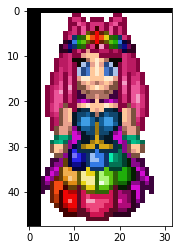

In [18]:
img = dataset[0]
img = (img + 1.0) * 127.5
img = np.round(img)
img = np.clip(img, 0, 255)
img = img.astype(np.uint8)
import matplotlib.pyplot as plt
plt.imshow(img)

In [19]:
params

{'discriminator_batches': 1,
 'fake_samples_multiplier': 0.9,
 'n_batch': 128,
 'n_epochs': 2000,
 'real_samples_multiplier': 0.1}

In [ ]:
d_model = define_discriminator(shape)
g_model = define_generator(latent_dim, shape)
gan_model = define_gan(g_model, d_model)
history = train(g_model, d_model, gan_model, dataset, latent_dim, output_path, **params)

epoch: 1, discriminator_real_loss=0.152, discriminator_fake_loss=0.163, generator_loss=0.158
epoch: 2, discriminator_real_loss=0.010, discriminator_fake_loss=0.010, generator_loss=0.810
epoch: 3, discriminator_real_loss=0.019, discriminator_fake_loss=0.023, generator_loss=0.722
epoch: 4, discriminator_real_loss=0.051, discriminator_fake_loss=0.071, generator_loss=0.686
epoch: 5, discriminator_real_loss=0.021, discriminator_fake_loss=0.086, generator_loss=0.633
epoch: 6, discriminator_real_loss=0.018, discriminator_fake_loss=0.056, generator_loss=0.706
epoch: 7, discriminator_real_loss=0.043, discriminator_fake_loss=0.011, generator_loss=0.659
epoch: 8, discriminator_real_loss=0.052, discriminator_fake_loss=0.009, generator_loss=0.788
epoch: 9, discriminator_real_loss=0.045, discriminator_fake_loss=0.015, generator_loss=0.714
epoch: 10, discriminator_real_loss=0.046, discriminator_fake_loss=0.031, generator_loss=0.705
epoch: 11, discriminator_real_loss=0.047, discriminator_fake_loss=0.0